# Camadas de CNN

Neste script vamos conhecer na prática as principais camadas que compõem redes neurais convolucionais. São elas:
- Convolucional
- Pooling
- Batch Normalization

Mas antes de tudo, vamos fazer os imports.

In [0]:
import torch
from torch import nn
from skimage import data

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Convolucional

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d

Começando pela operação principal, a convolução está contida na camada ```nn.Conv2d```. Dentre os parâmetros que ela recebe, vamos focar nos que já conhecemos, que já são suficientes para uma diversa gama de aplicações. 

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
```

**```in_channels```**<br>
Assim como toda camada, seu primeiro parâmetro é referente ao **tamanho da entrada**. Não é necessário explicitar as 2 primeiras dimensões da entrada, apenas a profundidade, que corresponde à **quantidade de canais**.

**```out_channels```** <br>
Independentemente do número de canais de entrada, um único filtro convolucional terá como resultado um canal de saída. Alterando esse parâmetro estamos na verdade definindo o **número de filtros** que irão compor essa camada, interferindo na quantidade de neurônios dessa camada.

> Dica: Nas arquiteturas de redes neurais mais populares, aumentamos a dimensão do canal à medida que avançamos na rede neural, geralmente diminuindo a resolução.

**```kernel_size```** <br>
Tamanho dos filtros convolucionais. Pode ser uma tupla ou um único número. Ex: ```kernel_size = 3``` criará filtros $3 \times 3$

**```stride```** <br>
Controla o pulo da convolução ao longo da imagem. 

**```padding```** <br>
Preenchimento com zeros nas bordas da imagem.

Vamos brincar um pouco com a camada convolucional para entender o seu funcionamento. Para isso, considere duas amostras de entrada retiradas do módulo ```skimage```:
* [brick](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.brick) : Imagem preta e branca de uma parede de tijolos
* [astronaut](https://scikit-image.org/docs/dev/api/skimage.data.html#skimage.data.astronaut) : Imagem colorida da astronauta Eileen Collins

Brick:  (512, 512)
Astronaut:  (512, 512, 3)


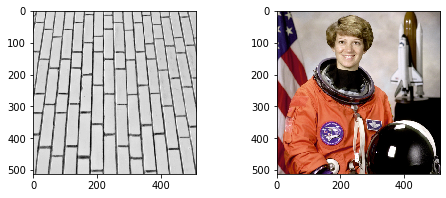

In [2]:
pb  = data.brick()
print("Brick: ", pb.shape)
rgb = data.astronaut()
print("Astronaut: ", rgb.shape)

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].imshow(pb, cmap='Greys')
axs[1].imshow(rgb)
plt.show()

Na célula a seguir vamos definir uma camada convolucional para realizar o forward na figura *brick*. Para isso, preste atenção em alguns detalhes:

* A entrada deve ser um dado tipo Tensor.
* A camada Convolucional espera uma entrada com as seguintes dimensões:
 $B \times C \times H \times W$

In [0]:
## Converter a imagem pb em um tensor e arrumar as dimensões 
pb_tns = torch.Tensor(pb).view(1, 1, pb.shape[0], pb.shape[1])
print("Dimensões da entrada:",pb_tns.shape, '\n')

## Definir a camada convolucional e realizar o forward
conv = nn.Conv2d(1, 6, kernel_size=3, padding=1)
feature_map = conv(pb_tns) 

print("Dimensões da saída:",feature_map.shape, '\n')

Dimensões da entrada: torch.Size([1, 1, 512, 512]) 

Dimensões da saída: torch.Size([1, 6, 512, 512]) 



Agora vamos fazer o mesmo para a figura da astronauta. O que deve mudar em relação à célula anterior?

* Em PyTorch a dimensão dos canais deve vir primeiro
* A definição da camada deve comportar uma entrada com 3 canais.

In [3]:
## Converter a imagem pb em um tensor e arrumar as dimensões 
rgb_tns = torch.Tensor(rgb).permute(2, 0, 1)
rgb_tns = rgb_tns.unsqueeze(0) 
print("Dimensões da entrada:",rgb_tns.shape, '\n')

## Definir a camada convolucional e realizar o forward
conv = nn.Conv2d(3, 6, kernel_size=3, padding=1)
feature_map = conv(rgb_tns) 

print("Dimensões da saída:",feature_map.shape, '\n')

Dimensões da entrada: torch.Size([1, 3, 512, 512]) 

Dimensões da saída: torch.Size([1, 6, 512, 512]) 



## Pooling

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d

```python
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)
```

**```kernel_size```** <br>
Tamanho dos *Field of View*. Pode ser uma tupla ou um único número. Ex: ```kernel_size = 3``` definirá FoV de $3 \times 3$

**```stride```** <br>
Controla o pulo da janela deslizante. 

**```padding```** <br>
Preenchimento com zeros nas bordas da imagem.

In [0]:
X = torch.FloatTensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
X = X.unsqueeze(0)
print(X.shape)
print(X, '\n')

pool = nn.MaxPool2d(kernel_size=2, stride=1)
y = pool(X)
print(y.shape)
print(y)

torch.Size([1, 3, 3])
tensor([[[0., 1., 2.],
         [3., 4., 5.],
         [6., 7., 8.]]]) 

torch.Size([1, 2, 2])
tensor([[[4., 5.],
         [7., 8.]]])


Ao processar dados com múltiplos canais, a camada de pooling processa cada canal de entrada separadamente ao invés de processar todos os canais como em uma camada convolucional. Isso significa que **o número de canais de saída para a camada de pooling é o mesmo que o número de canais de entrada**. 

Vamos processar abaixo a imagem da astronauta.

In [6]:
print('Feature Map:', feature_map.shape)

pool = nn.MaxPool2d(kernel_size=3)
y = pool(feature_map)
print('Saída:', y.shape)

Feature Map: torch.Size([1, 6, 512, 512])
Saída: torch.Size([1, 6, 170, 170])


## Batch Normalization

Documentação: https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d

```python
torch.nn.BatchNorm2d(num_features)
```

**```num_features```**<br>
$\mathbf{\gamma}$ e $\mathbf{\beta}$ são aprendidos individualmente para cada canal da entrada. Em ativações de camadas intermediárias, esse valor corresponde ao **número de feature maps**. 


In [7]:
ConvolutionBlock = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3),
)

minibatch = torch.cat(12*[rgb_tns])
print("Entrada:", minibatch.shape)

y = ConvolutionBlock(minibatch)
print("Saída:", y.shape)

Entrada: torch.Size([12, 3, 512, 512])
Saída: torch.Size([12, 16, 170, 170])


## LeNet 5

<img src="https://drive.google.com/uc?export=view&id=1BThCsFE8fSCe012klZmp8UpslOlzWsmK" width="800">

<img src="https://drive.google.com/uc?export=view&id=1oG_Jh8nA2Nrq8RTcIyJEOaIXXxa10Srw" width="700">

In [0]:
net = nn.Sequential(
        ## ConvBlock 1
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),        # entrada: (b, 1, 32, 32) e saida: (b, 6, 28, 28)
        nn.BatchNorm2d(6),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 6, 28, 28) e saida: (b, 6, 14, 14)
        
        ## ConvBlock 2
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),       # entrada: (b, 6, 14, 14) e saida: (b, 16, 10, 10)
        nn.BatchNorm2d(16),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           # entrada: (b, 16, 10, 10) e saida: (b, 16, 5, 5)
        
        ## ConvBlock 3
        nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),     # entrada: (b, 16, 5, 5) e saida: (b, 120, 1, 1)
        nn.BatchNorm2d(120),
        nn.Tanh(),
        nn.Flatten(),  # lineariza formando um vetor                # entrada: (b, 120, 1, 1) e saida: (b, 120*1*1) = (b, 120)
        
        ## DenseBlock
        nn.Linear(120, 84),                                         # entrada: (b, 120) e saida: (b, 84)
        nn.Tanh(),
        nn.Linear(84, 10),                                          # entrada: (b, 84) e saida: (b, 10)
        nn.Softmax(dim=-1))

In [9]:
data_transform = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),])

fashion_mnist = datasets.FashionMNIST('.', 
                                      train=False, 
                                      transform=data_transform, 
                                      download=True)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


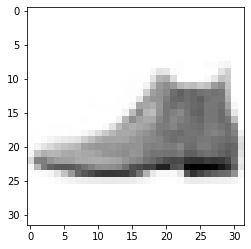

In [10]:
data, label = fashion_mnist[0]
plt.imshow(data[0], cmap='Greys')

In [11]:
minibatch = [data for k, (data, label) in enumerate(fashion_mnist) if k < 16]
minibatch = torch.stack(minibatch)
print("Entrada:", minibatch.shape)

y = net(minibatch)
print(y.shape)
print(y[0].data)

Entrada: torch.Size([16, 1, 32, 32])
torch.Size([16, 10])
tensor([0.1023, 0.0876, 0.0935, 0.1131, 0.1175, 0.0891, 0.1285, 0.0886, 0.0734,
        0.1064])
